Iterative Workflow in Langgraph
===============================================

In [77]:
from langgraph.graph import StateGraph,START,END
from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage, HumanMessage
from typing import TypedDict, Literal, Optional, Dict, Any
from pydantic import BaseModel, Field
from dotenv import load_dotenv

import os

In [78]:
load_dotenv()
HF_TOKEN = os.getenv("HF_KEY")
generate_llm = ChatOpenAI(
    model= "Qwen/Qwen2.5-7B-Instruct",
    api_key = HF_TOKEN,
    base_url="https://router.huggingface.co/v1",
    temperature=0,
    max_tokens = 500,
)
evaluate_llm = ChatOpenAI(
    model="deepseek-ai/DeepSeek-V3-0324",
    api_key = HF_TOKEN,
    base_url="https://router.huggingface.co/v1",
    temperature=0,
    max_tokens = 500,
)
optimize_llm = ChatOpenAI(
    model= "Qwen/Qwen2.5-7B-Instruct",
    api_key = HF_TOKEN,
    base_url="https://router.huggingface.co/v1",
    temperature=0,
    max_tokens = 500,
)

In [79]:
generate_llm.invoke("Hey! how are you?").content

"Hello! I'm just a digital assistant, so I don't have feelings, but I'm here and ready to help you with any questions or information you need. How can I assist you today?"

In [80]:
class TweetEvaluationSchema(BaseModel):
    evaluate: Literal['approved','needs_improvement'] = Field(..., description="final evaluation result")
    feedback: str = Field(..., description = "feedback for the tweet.")

In [81]:
structure_evaluator_llm = evaluate_llm.with_structured_output(TweetEvaluationSchema)

In [82]:
class TweetState(TypedDict):
    topic: str
    tweet: str
    evaluate: Literal['approved', 'needs_improvement']
    iteration: int
    max_iterations: int
    feedback: str

In [83]:
def generate_tweet(state: TweetState):
    messages = [
        SystemMessage(content = "You are a creative comedy writer for Twitter (X)."),
        HumanMessage(content = f"""

Task:
- The user will give you a TOPIC.
- Write ONE very funny tweet about that topic.

Rules:
- The tweet must be COMPLETELY ORIGINAL (never copied, never paraphrased from real tweets).
- Do NOT reference real tweets, memes, or viral formats.
- No hashtags.
- No emojis.
- No links.
- Max length: 280 characters.
- Use sharp humor, irony, or unexpected punchlines.
- The joke should feel fresh and surprising, not predictable.

Input:
Topic: {state['topic']}

Output:
Return ONLY the tweet text.
""")
    ]
    response = generate_llm.invoke(messages).content

    return {
        "tweet": response.strip()
    }

In [84]:
def evaluate_tweet(state: TweetState):
   message = [SystemMessage(content = "You are an expert content evaluator for social media platforms."),
   HumanMessage(content = f"""

Task:
Evaluate the given TWEET across multiple categories. 
This is NOT a question-answer task. 
Do NOT rewrite the tweet. Do NOT explain humor theory.

Rules:
- Be objective and concise.
- Evaluate ONLY what is present in the tweet.
- Do not assume intent beyond the text.
- Do not suggest improvements.

Input:
Tweet:
{state['tweet']}

Evaluation Categories:

1. Humor Quality 
   - Is it funny?
   - Is the punchline clear and effective?
   - Does it rely on cleverness rather than shock?

2. Originality
   - Does it feel fresh and non-generic?
   - Does it avoid common meme formats or recycled jokes?

3. Clarity & Readability 
   - Is the tweet easy to understand?
   - Is the joke delivered efficiently?

4. Ethics & Safety
   - Does it avoid hate, harassment, or harmful stereotypes?
   - Is it safe for a general audience?

5. Policy Compliance 
   - Would this tweet be acceptable on a major social platform?
   - Does it avoid misinformation or targeted abuse?

6. Joke Type Classification
   - Choose ONE:
     - Wordplay
     - Absurd / Surreal
     - Observational
     - Satire
     - Dark Humor
     - Dry / Deadpan
     - Not a Joke

7. Risk Level
   - Choose ONE:
     - Low
     - Medium
     - High

Response ONLY in struture formate:
- evaluation : 'approved' or 'needs_improvement'
- feedback: only one paragraph explaination the strength and weakness

""")]
   response  = structure_evaluator_llm.invoke(message)
   return {
         "evaluate": response.evaluate, 
         "feedback": response.feedback
      }

In [85]:
def optimize_tweet(state: TweetState):
    message = [
        SystemMessage(content = 'You are a professional social media content and comedy writer.'),
        HumanMessage(content = f"""
Improve the tweet based on this feedback:
{state.feedback}

Topic: {state['topic']}
original tweet: {state.tweet}

Rewrite it as a short, viral-worthy tweet. Avoid Q&A style and stay under 280 characters.
""")
    ]
    response = optimize_llm.invoke(message).content
    iteration = state.iteration + 1
    return {
        'tweet': response,
        "iteration": iteration
    }

In [86]:
def route_evaluation(state: TweetState) -> Literal['approved', 'needs_improvement']:
    if state.evaluate == 'approved' or state.iteration >= state.max_iterations:
        return "approved"
    else:
        return 'needs_improvement'

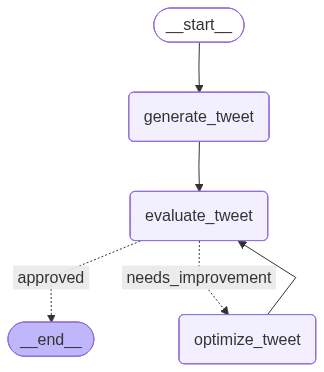

In [87]:
# ---Graph--- #
graph = StateGraph(TweetState)

# --- Add Nodes --- #
graph.add_node("generate_tweet", generate_tweet)
graph.add_node("evaluate_tweet", evaluate_tweet)
graph.add_node("optimize_tweet", optimize_tweet)

# Define Edges
graph.add_edge(START, 'generate_tweet')
graph.add_edge('generate_tweet', 'evaluate_tweet')
graph.add_conditional_edges('evaluate_tweet', route_evaluation, {"approved": END, 'needs_improvement': 'optimize_tweet'})
graph.add_edge('optimize_tweet', 'evaluate_tweet')


workflow = graph.compile()
workflow

In [88]:
initial_state = {
    'topic': 'Local Bus',
    'iteration': 1,
    'max_iterations': 5,
}
workflow.invoke(initial_state)

AttributeError: 'dict' object has no attribute 'evaluate'